# Creation of a neural network

In this task, a fully connected neural network is created using tensorflow's low-level mechanisms.

The architecture of the neural network is presented in the following figure. As you can see, it has one input layer, two hidden layers, and an output layer. The sigmoid will be used as the activation function in the hidden layers. On the output layer we use softmax.

## Neural network architecture

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## About the MNIST dataset

This neural network will be studied on the MNIST dataset. This dataset is a large number of images of handwritten digits of size $28 \times 28$ pixels. Each pixel takes a value from 0 to 255.

The dataset will be divided into training and test samples. At the same time, all images are normalized so that the pixel value is between 0 and 1 by dividing the brightness of each pixel by 255.

In addition, the architecture of the neural network expects an input vector. In our case, each sample object is a matrix. What to do? In this task, the matrix $28 \times 28$ will be "stretched", thus obtaining a vector consisting of 784 elements.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

More information about the dataset can be found [here](http://yann.lecun.com/exdb/mnist/).

Imports

In [167]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

Constants

In [168]:
num_classes = 10 # the total number of classes, in our case these are numbers from 0 to 9
num_features = 784 # the number of attributes of the input vector is 28 * 28 = 784

learning_rate = 0.001 # learning speed of the neural network
training_steps = 3000 # the maximum number of epochs
batch_size = 256 # network weights will be calculated not on the entire sample, but on its random subset of batch_size elements
display_step = 100 # every 100 iterations the current value of the loss function and accuracy will be displayed

n_hidden_1 = 128 # the number of neurons of the 1st layer
n_hidden_2 = 256 # the number of neurons of the 2nd layer

DataSet loading and visualization

In [169]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(x_train.shape)  # matric images of numbers
print(x_test.shape)

print(y_train.shape)  # labels of the numbers
print(y_test.shape)

print(x_test[0])  # graphic image of the number 7 converted to digital matrix
print(y_test[0])  # label of the image - number 7

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 

In [170]:
def display_25_random_examples(examples, labels):
    plt.figure(figsize=(10, 10))

    for i in range(25):
        idx = np.random.randint(0, examples.shape[0] - 1)
        img = examples[idx]
        label = labels[idx]

        plt.subplot(5, 5, i + 1)  # subplots with numbers organized in 5 rows & columns
        plt.title(str(label))
        plt.tight_layout()  # regulates spaces between subplots with numbers
        plt.imshow(img, cmap="Blues")  # prints matrices with "Blues" color scheme

    plt.show()

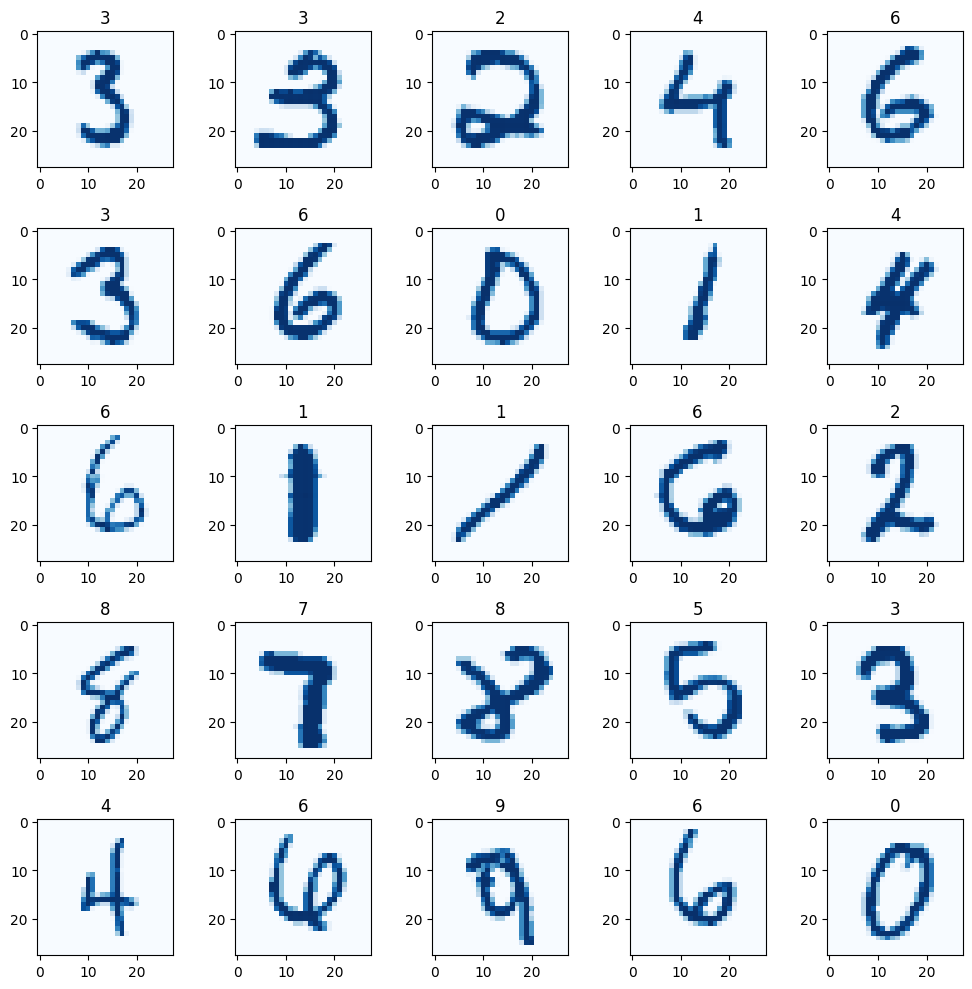

In [171]:
display_25_random_examples(x_test, y_test)

Normalization

In [172]:
# Normalizing and converting to float32 type
x_train_norm = x_train.astype("float32") / 255
x_test_norm = x_test.astype("float32") / 255

# Converting 28x28 pixel matrices into a tensor vector of 784 elements
x_train_vector = x_train_norm.reshape([-1, num_features])
x_test_vector = x_test_norm.reshape([-1, num_features])

# Mixing the training data
train_data = tf.data.Dataset.from_tensor_slices((x_train_vector, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [173]:
print(x_train_vector.shape)  # (60000, 784) before normalization was (60000, 28, 28)
print(x_test_vector.shape)  # (10000, 784) before normalization was (10000, 28, 28)

(60000, 784)
(10000, 784)


Creating a neural network with 2 hidden layers

In [174]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b") # b is simply 0

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b  # y = w * x + b
        if activation != 0:
            return tf.nn.softmax(y)  # SoftMax activation function
        else:
            return tf.nn.sigmoid(y)  # Sigmpid activation function


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # The first layer, which consists of 128 neurons
        self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
        # The second layer, which consists of 256 neurons
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
        # Output layer
        self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")

    def __call__(self, x):
        # Data transmission through the first two layers and the output layer with softmax activation function
        x = self.layer1(x, activation=0)
        x = self.layer2(x, activation=0)
        x = self.out_layer(x, activation=1)

        return x

Cross-entropy as the error function

In [175]:
def cross_entropy(y_pred, y_true):
    # The label encoding into one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction value to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Calculation of cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

Quality metrics

In [176]:
def accuracy(y_pred, y_true):
    # Comparing the predicted values with the true labels
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Calculating the average accuracy using convolution
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [177]:
def all_metrics(truth, prediction):
    predict = tf.argmax(prediction, 1).numpy()  # converting tf array to np vector

    ac = tf.keras.metrics.Accuracy()  # accuracy calculation
    ac.update_state(truth, predict)
    accuracy = ac.result().numpy()

    pr = tf.keras.metrics.Precision()  # precision calculation
    pr.update_state(truth, predict)
    precision = pr.result().numpy()

    re = tf.keras.metrics.Recall()  # recall calculation
    re.update_state(truth, predict)
    recall = re.result().numpy()

    f1score = 2 * precision * recall / (precision + recall)  # F1 score calculation

    return accuracy, precision, recall, f1score

The learning function of the neural network

In [178]:
def train(neural_net, input_x, output_y):
  # To adjust the weights of the network, stochastic gradient descent is used
  optimizer = tf.optimizers.SGD(learning_rate)

  # Activation of automatic differentiation
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Getting a list of optimized parameters
    trainable_variables = neural_net.trainable_variables

    # Calculating the value of the gradient based on them
    gradients = g.gradient(loss, trainable_variables)

    # Modifying the parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))

Creating an instance of a neural network

In [179]:
neural_net = NN(name="mnist")

Network training

In [180]:
loss_history = []  # every 'display_step' of steps saving the current error of the neural network in this list
accuracy_history = [] # every 'display_step' of steps store the current accuracy of the neural network in this list

# A random subset is drawn from the training dataset train_data on which training will take place.
# The 'take' method available for the training dataset is used.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Updating the weights of the neural network
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss function: {loss}, Accuracy: {acc}")

Step: 100, Loss function: 313.216552734375, Accuracy: 0.6796875
Step: 200, Loss function: 248.275634765625, Accuracy: 0.70703125
Step: 300, Loss function: 168.1029052734375, Accuracy: 0.78515625
Step: 400, Loss function: 159.53811645507812, Accuracy: 0.8203125
Step: 500, Loss function: 135.59591674804688, Accuracy: 0.84375
Step: 600, Loss function: 141.97828674316406, Accuracy: 0.8125
Step: 700, Loss function: 123.43386840820312, Accuracy: 0.859375
Step: 800, Loss function: 96.52017211914062, Accuracy: 0.875
Step: 900, Loss function: 80.62332153320312, Accuracy: 0.90625
Step: 1000, Loss function: 80.95040130615234, Accuracy: 0.90234375
Step: 1100, Loss function: 96.33134460449219, Accuracy: 0.88671875
Step: 1200, Loss function: 101.57661437988281, Accuracy: 0.87109375
Step: 1300, Loss function: 109.30424499511719, Accuracy: 0.88671875
Step: 1400, Loss function: 92.327392578125, Accuracy: 0.89453125
Step: 1500, Loss function: 62.41716003417969, Accuracy: 0.91015625
Step: 1600, Loss func

Graphs of the dependence of changes in accuracy and losses on the step (accuracy should increase and losses should decrease)

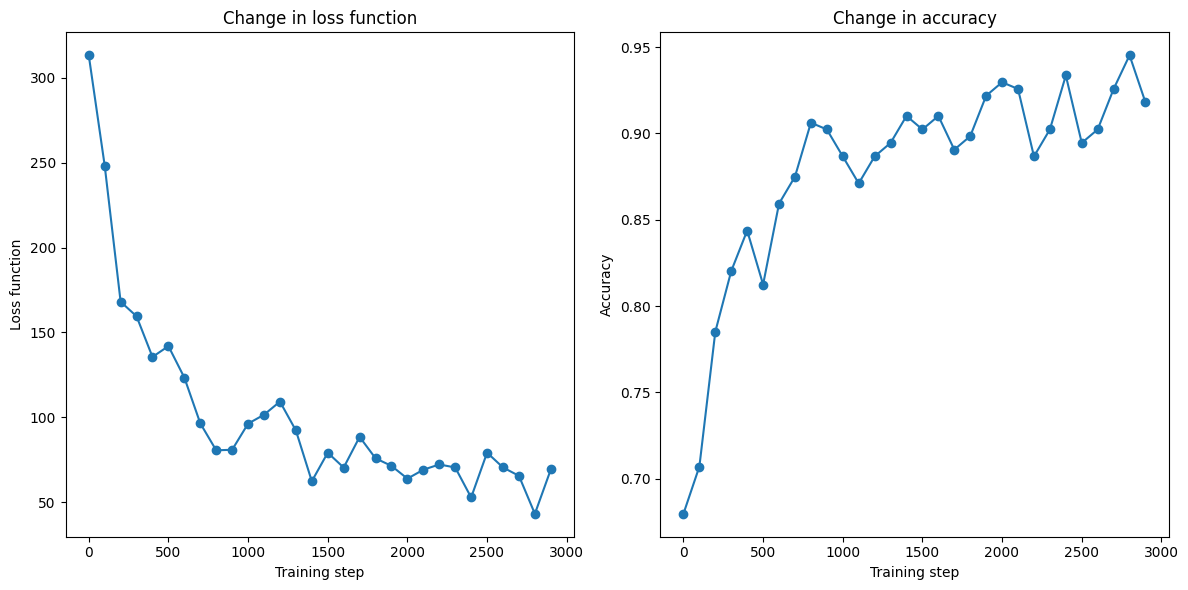

In [181]:
# Graph of the loss function
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Change in loss function')
plt.xlabel('Training step')
plt.ylabel('Loss function')

# Graph of the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.title('Change in accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Calculation of the accuracy of the trained neural network

In [182]:
# Model testing on test data
test_pred = neural_net(x_test_vector)

In [183]:
metrics = all_metrics(y_test, test_pred)

print(f"Accuracy on test data:  {metrics[0]*100:.2f}%")
print(f"Precision on test data: {metrics[1]*100:.2f}%")
print(f"Recall on test data:    {metrics[2]*100:.2f}%")
print(f"F1 Score on test data:  {metrics[3]*100:.2f}%")

Accuracy on test data:  90.00%
Precision on test data: 99.43%
Recall on test data:    99.32%
F1 Score on test data:  99.38%


Testing the trained neural network on 10 random images

C:\Users\danie\AppData\Local\Temp\ipykernel_21536\2510222093.py:16: RuntimeWarning: invalid value encountered in scalar divide
  f1score = 2 * precision * recall / (precision + recall)  # F1 score calculation


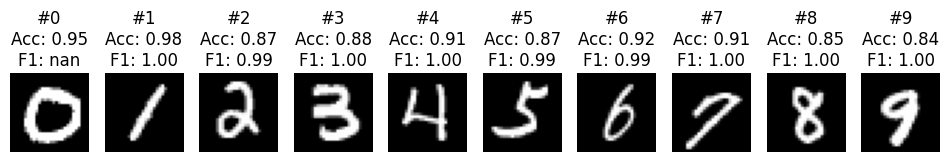

In [184]:
# Choosing images to plot
# indices = random.sample(range(len(x_test)), 10)
sorter = np.argsort(y_test)
numbers = np.array([i for i in range(10)])
indices = sorter[np.searchsorted(y_test, numbers, sorter=sorter)]
test_images = x_test[indices]

# Display the image and the answer of the neural network next to it
plt.figure(figsize=(12, 6))
for i in range(10):
    metrix = all_metrics(y_test[y_test == i], test_pred[y_test == i])

    plt.subplot(1, 10, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"#{i}\nAcc: {metrix[0]:.2f}\nF1: {metrix[3]:.2f}")
    plt.axis('off')

plt.show()

### Conclusion

Based on the results on the training data, the model performed well, as the accuracy in 3.000 epochs = 0.91 and F1 score = 0.99. Quality metrics on each digit is in line with model's accuracy and F1 score.

Based on the results of training and testing, it is possible to draw conclusions about the quality of the trained network, its effectiveness in solving the task of recognizing handwritten digits, and possible ways of further improvement.